In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [2]:
df = pd.read_csv('heart.csv')

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [5]:
# Define the continuous features
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Identify the features to be converted to object data type
features_to_convert = [feature for feature in df.columns if feature not in continuous_features]

# Convert the identified features to object data type
df[features_to_convert] = df[features_to_convert].astype('object')

df.dtypes

age           int64
sex          object
cp           object
trestbps      int64
chol          int64
fbs          object
restecg      object
thalach       int64
exang        object
oldpeak     float64
slope        object
ca           object
thal         object
target       object
dtype: object

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
trestbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
thalach,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [8]:
df.describe(include='object').T

,count,unique,top,freq
sex,303,2,1,207
cp,303,4,0,143
fbs,303,2,0,258
restecg,303,3,1,152
exang,303,2,0,204
slope,303,3,2,142
ca,303,5,0,175
thal,303,4,2,166
target,303,2,1,165


In [22]:
# df.loc[(df['cp'] == 0)].

(143, 14)

EDA

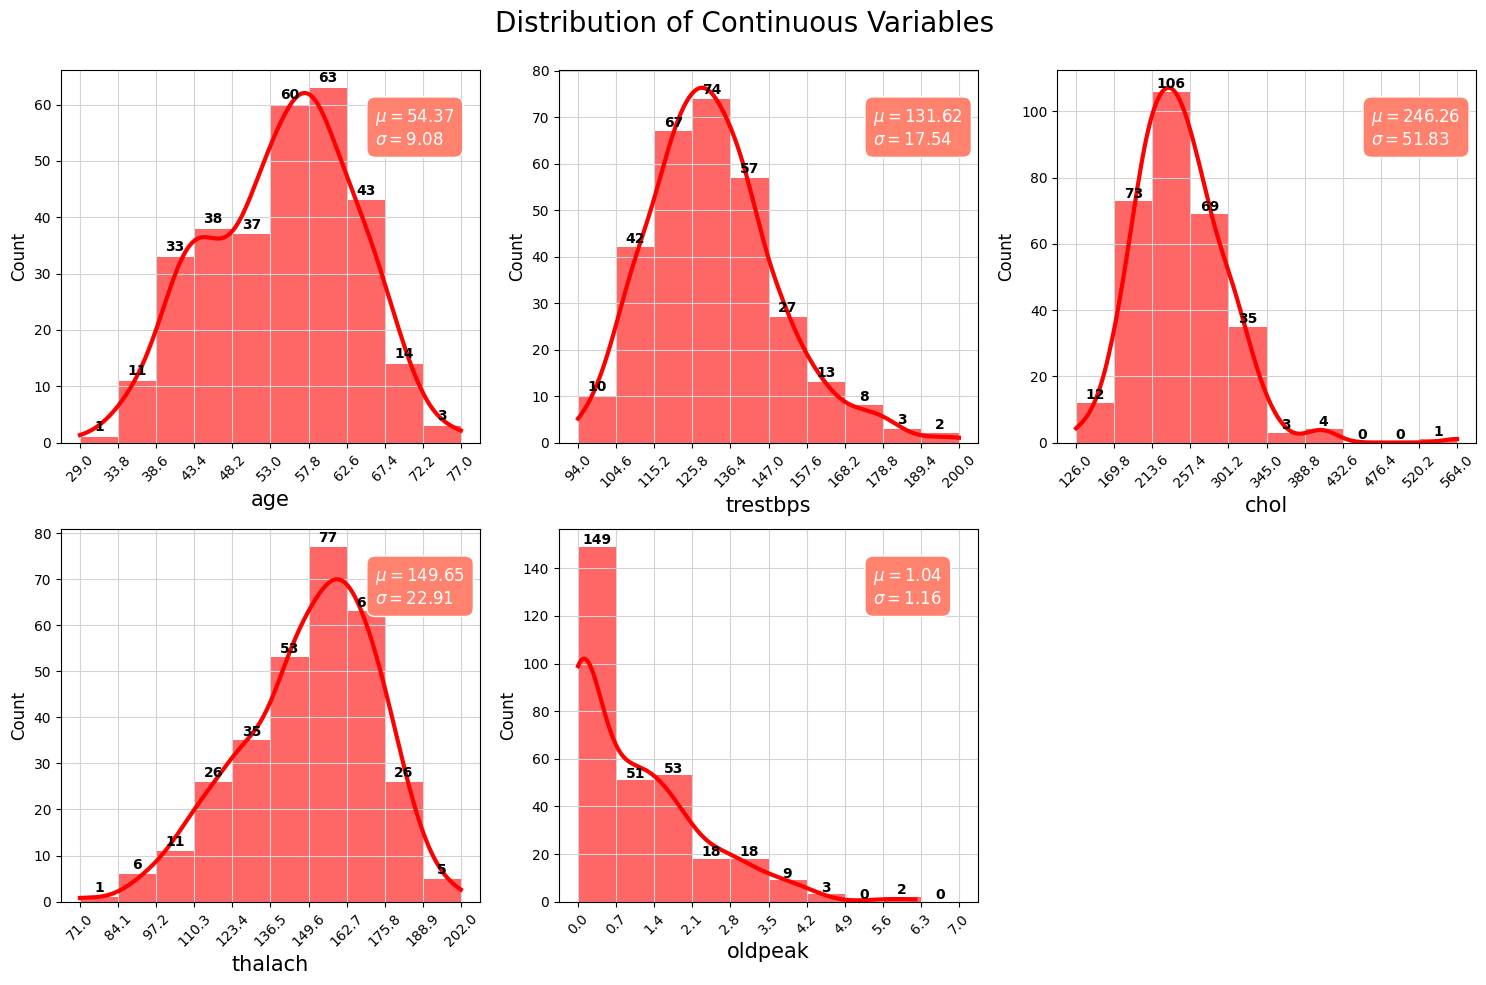

In [26]:
# Filter out continuous features for the univariate analysis
df_continuous = df[continuous_features]

# Set up the subplot
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Loop to plot histograms for each continuous feature
for i, col in enumerate(df_continuous.columns):
    x = i // 3
    y = i % 3
    values, bin_edges = np.histogram(df_continuous[col], 
                                     range=(np.floor(df_continuous[col].min()), np.ceil(df_continuous[col].max())))
    
    graph = sns.histplot(data=df_continuous, x=col, bins=bin_edges, kde=True, ax=ax[x, y],
                         edgecolor='none', color='red', alpha=0.6, line_kws={'lw': 3})
    ax[x, y].set_xlabel(col, fontsize=15)
    ax[x, y].set_ylabel('Count', fontsize=12)
    ax[x, y].set_xticks(np.round(bin_edges, 1))
    ax[x, y].set_xticklabels(ax[x, y].get_xticks(), rotation=45)
    ax[x, y].grid(color='lightgrey')
    
    for j, p in enumerate(graph.patches):
        ax[x, y].annotate('{}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() + 1),
                          ha='center', fontsize=10, fontweight="bold")
    
    textstr = '\n'.join((
        r'$\mu=%.2f$' % df_continuous[col].mean(),
        r'$\sigma=%.2f$' % df_continuous[col].std()
    ))
    ax[x, y].text(0.75, 0.9, textstr, transform=ax[x, y].transAxes, fontsize=12, verticalalignment='top',
                  color='white', bbox=dict(boxstyle='round', facecolor='#ff826e', edgecolor='white', pad=0.5))

ax[1,2].axis('off')
plt.suptitle('Distribution of Continuous Variables', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [27]:
categorical_features = df.columns.difference(continuous_features)
df_categorical = df[categorical_features]

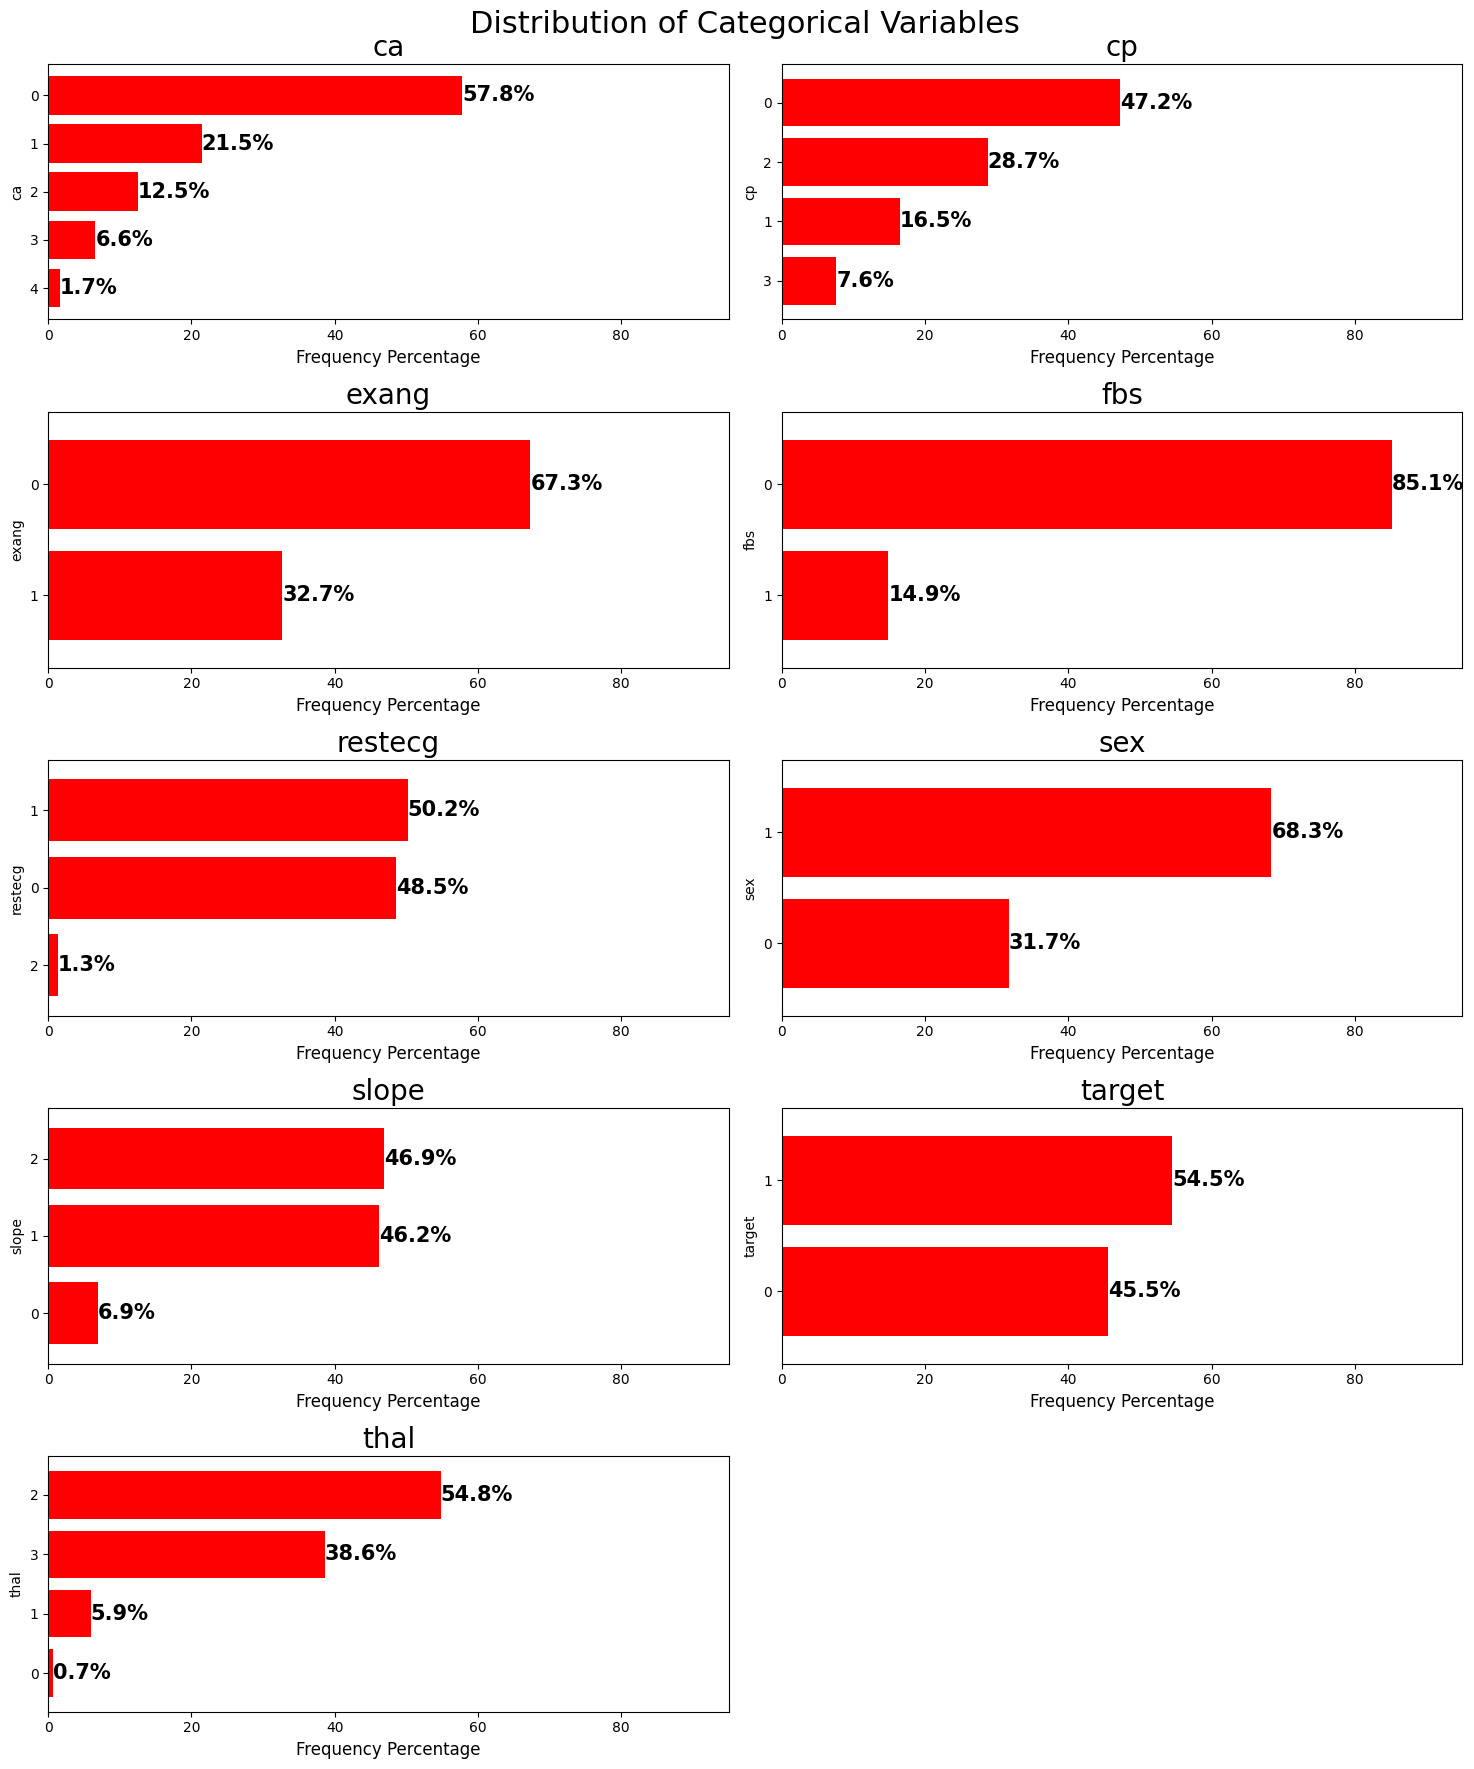

In [28]:
# Set up the subplot for a 4x2 layout
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 18))

# Loop to plot bar charts for each categorical feature in the 4x2 layout
for i, col in enumerate(categorical_features):
    row = i // 2
    col_idx = i % 2
    
    # Calculate frequency percentages
    value_counts = df[col].value_counts(normalize=True).mul(100).sort_values()
    
    # Plot bar chart
    value_counts.plot(kind='barh', ax=ax[row, col_idx], width=0.8, color='red')
    
    # Add frequency percentages to the bars
    for index, value in enumerate(value_counts):
        ax[row, col_idx].text(value, index, str(round(value, 1)) + '%', fontsize=15, weight='bold', va='center')
    
    ax[row, col_idx].set_xlim([0, 95])
    ax[row, col_idx].set_xlabel('Frequency Percentage', fontsize=12)
    ax[row, col_idx].set_title(f'{col}', fontsize=20)

ax[4,1].axis('off')
plt.suptitle('Distribution of Categorical Variables', fontsize=22)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

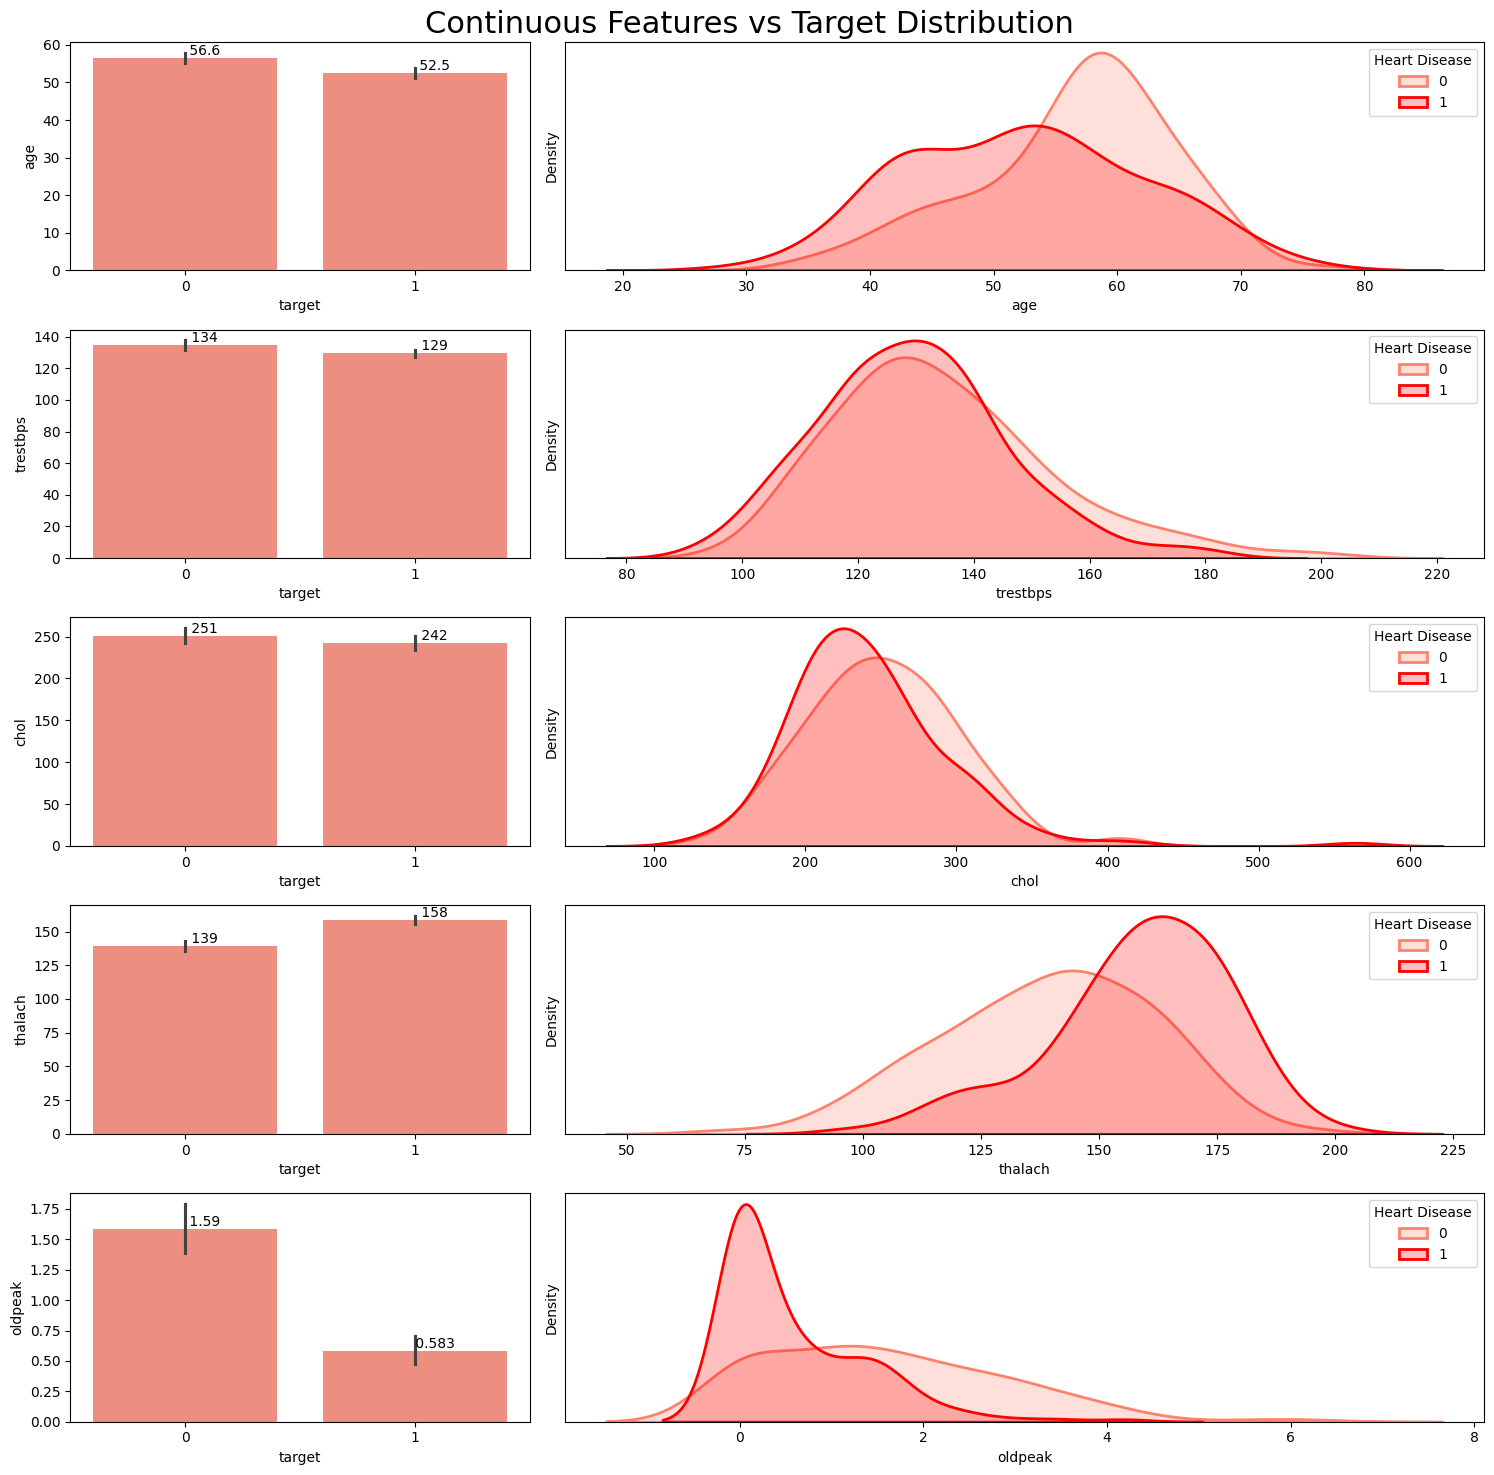

In [29]:
# Set color palette
sns.set_palette(['#ff826e', 'red'])

# Create the subplots
fig, ax = plt.subplots(len(continuous_features), 2, figsize=(15,15), gridspec_kw={'width_ratios': [1, 2]})

# Loop through each continuous feature to create barplots and kde plots
for i, col in enumerate(continuous_features):
    # Barplot showing the mean value of the feature for each target category
    graph = sns.barplot(data=df, x="target", y=col, ax=ax[i,0])
    
    # KDE plot showing the distribution of the feature for each target category
    sns.kdeplot(data=df[df["target"]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=df[df["target"]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Heart Disease', loc='upper right')
    
    # Add mean values to the barplot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='         %.3g')
        
# Set the title for the entire figure
plt.suptitle('Continuous Features vs Target Distribution', fontsize=22)
plt.tight_layout()                     
plt.show()


In [30]:
# Remove 'target' from the categorical_features
categorical_features = [feature for feature in categorical_features if feature != 'target']

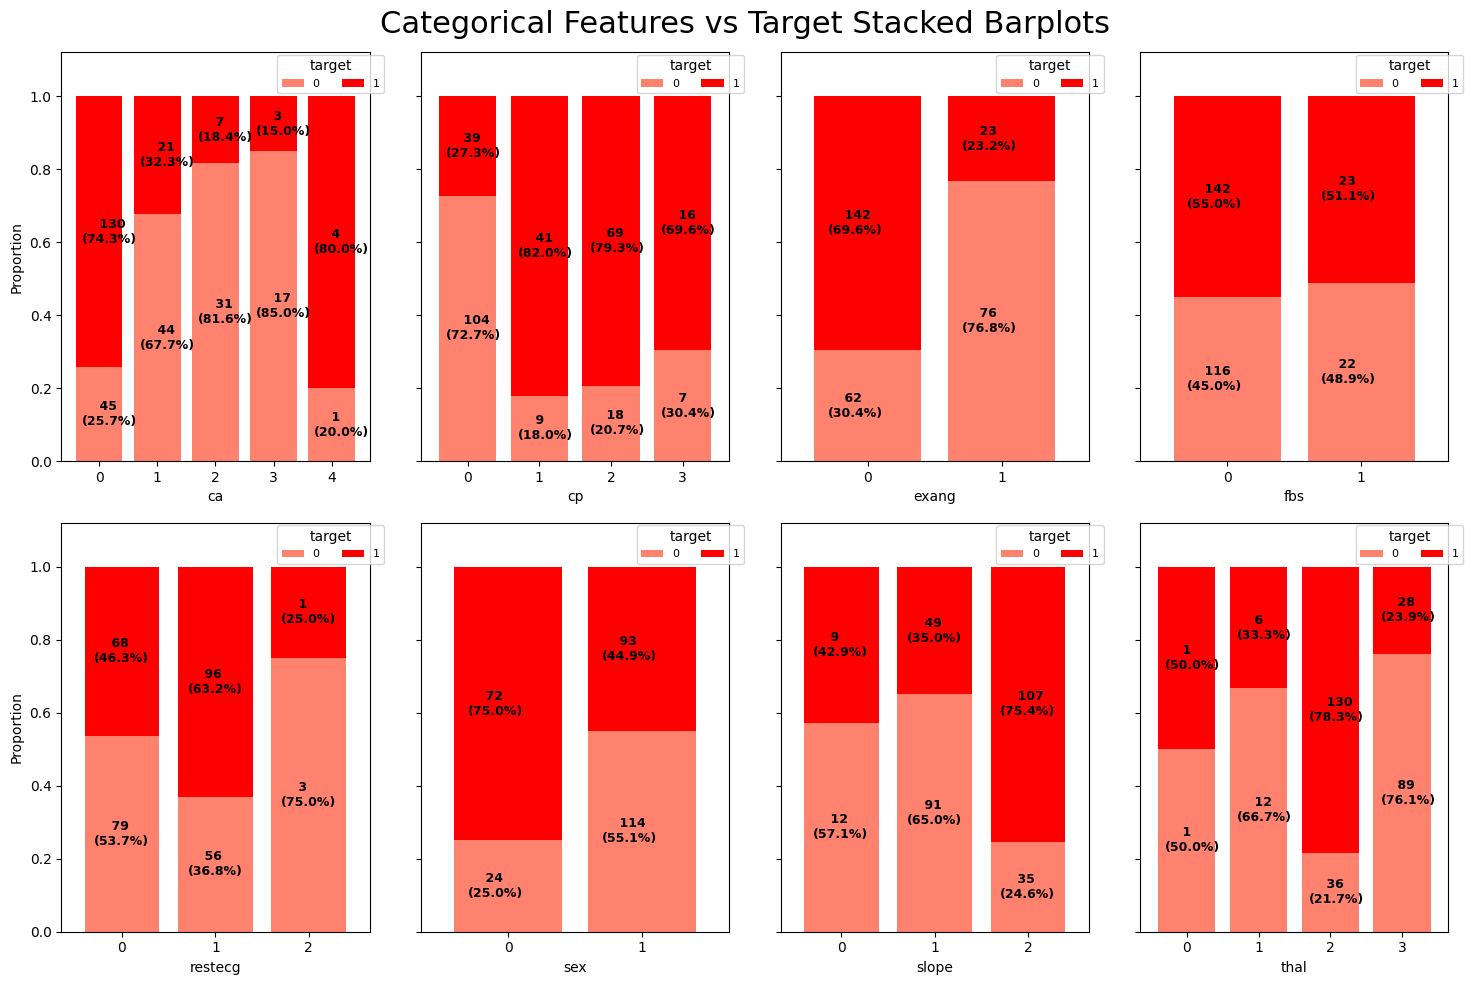

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,10))

for i,col in enumerate(categorical_features):
    
    # Create a cross tabulation showing the proportion of purchased and non-purchased loans for each category of the feature
    cross_tab = pd.crosstab(index=df[col], columns=df['target'])
    
    # Using the normalize=True argument gives us the index-wise proportion of the data
    cross_tab_prop = pd.crosstab(index=df[col], columns=df['target'], normalize='index')

    # Define colormap
    cmp = ListedColormap(['#ff826e', 'red'])
    
    # Plot stacked bar charts
    x, y = i//4, i%4
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='Proportion', sharey=True)
    
    # Add the proportions and counts of the individual bars to our plot
    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.3, y=(y_location-proportion)+(proportion/2)-0.03,
                         s = f'    {count}\n({np.round(proportion * 100, 1)}%)', 
                         color = "black", fontsize=9, fontweight="bold")
    
    # Add legend
    ax[x,y].legend(title='target', loc=(0.7,0.9), fontsize=8, ncol=2)
    # Set y limit
    ax[x,y].set_ylim([0,1.12])
    # Rotate xticks
    ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(), rotation=0)
    
            
plt.suptitle('Categorical Features vs Target Stacked Barplots', fontsize=22)
plt.tight_layout()                     
plt.show()

Data Preprocessing

In [32]:
# Check for missing values in the dataset
df.isnull().sum().sum()

0

In [33]:
continuous_features

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [34]:
Q1 = df[continuous_features].quantile(0.25)
Q3 = df[continuous_features].quantile(0.75)
IQR = Q3 - Q1
outliers_count_specified = ((df[continuous_features] < (Q1 - 1.5 * IQR)) | (df[continuous_features] > (Q3 + 1.5 * IQR))).sum()

outliers_count_specified

age         0
trestbps    9
chol        5
thalach     1
oldpeak     5
dtype: int64